# MAGNets Tutorial

In this Jupyter Notebook, our goal is to explore **model skeletonization** options provided by **MAGNets**.

For our analyses, we will use BWFLNet, a model of a real water distribution network. The Bristol Water Field Lab (BWFL) network is part of the water distribution network of the city of Bristol, UK, and it serves approximately 8,000 customer connections. BWFLnet is an operational network in Bristol, UK, operated by Bristol Water. The data provided is a the product of a long term research partnership between Bristol Water and Infrasense Labs at Imperial College London. The BWFLnet model and data set can be found [here](https://data.mendeley.com/datasets/srt4vr5k38/1).

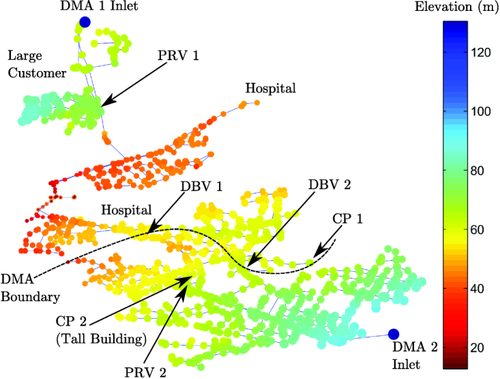

# 1. Getting Started

## 1.1. Imports

Our first step is to install and import the Python packages we need into this file:

In [1]:
#!pip install wntr matplotlib numpy magnets viswaternet 

In [2]:
%matplotlib inline

#import packages
import wntr
import matplotlib.pyplot as plt
import numpy as np
import time
import viswaternet as vis

## 1.2. Create water network model 

Let us begin by defining the .INP file of the model and initializing a water network model object using WNTR. Note that this model has been slightly modified from the original model in the following ways:
1. some demand patterns are exactly the same as others so we have merged them
2. all throttle control valves (TCVs) in the model have been replaced with equivalent pipes

In [3]:
# import bwfl
inp = 'networks/BWFLnet_modified.inp'

# initialize water network model object
wn = wntr.network.WaterNetworkModel(inp)

# initialize viswaternet model object
model=vis.VisWNModel(inp)

## 1.3. Run hydraulic simulation

We will now run a hydraulic simulation with WNTR (using the EPANET 2.2 engine), store the simulation time, and examine the number of components in the network.

In [4]:
# run wntr simulation and record simulation time
sim = wntr.sim.EpanetSimulator(wn)

t1 = time.time()
results = sim.run_sim()
t2 = time.time()

simtime = t2-t1
print('The simulation run time was ', simtime, 's')

# describe the number of components in the system
wn.describe()

The simulation run time was  0.26354527473449707 s


{'Nodes': 2548,
 'Links': 2606,
 'Patterns': 9,
 'Curves': 0,
 'Sources': 0,
 'Controls': 0}

## 1.4. Define critical nodes

Remember that this real network has several important junctions that we want to keep track of. Here, we define (1) a list of junction names representing locations of pressure sensors, (2) a list of junctions that are assigned different demand patterns, and (3) their neighboring nodes.

In [5]:
# list of junctions where pressure sensors are installed
pressure_sensors_list = ['node_1925', 'node_1938', 'node_1961', 'node_1971', 
                         'node_1983', 'node_0354', 'node_2012', 'node_2046', 
                         'node_2113', 'node_0785', 'node_2188', 'node_2197', 
                         'node_2210', 'node_2243', 'node_2265', 'node_2285', 
                         'node_1194', 'node_1202', 'node_2354', 'node_2428', 
                         'node_2440', 'node_2441', 'node_1738', 'node_2485', 
                         'node_1781', 'node_1876', 'node_2535']

# list of junctions with different demand patterns ...
diff_demand_pattern_list = ['node_0640', 'node_0870', 'node_0973', 'node_1122', 'node_1311', 
                            'node_1363', 'node_1388', 'node_1685', 'node_1813', 'node_2125', 
                            'node_2130', 'node_2167', 'node_2184', 'node_2220', 'node_2307']

# ... and their neighbors
diff_demand_neighbor_list = ['node_0595', 'node_0647', 'node_0648', 'node_2168', 'node_2152', 
                             'node_0907', 'node_0952', 'node_2199', 'node_2206', 'node_1121',
                             'node_2260', 'node_1315', 'node_1340', 'node_2350', 'node_1385',
                             'node_1386', 'node_1402', 'node_2439', 'node_2446', 'node_2456',
                             'node_1807', 'node_0718', 'node_2140', 'node_2112', 'node_0755',
                             'node_0890', 'node_0868', 'node_0913', 'node_0984', 'node_1037',
                             'node_1223', 'node_1262']

# list of all critical nodes
critical_nodes = pressure_sensors_list + diff_demand_pattern_list + diff_demand_neighbor_list

# 2. Model Reduction Using MAGNets

We see that the BWFLNet model has over 2,500 nodes and links and 5 valves. Hydraulic models of complex water networks, such as this one, can be expensive to run in terms of computational effort and time. Therefore, we can turn to **reduced** or **skeletonized** models to speed up model running times and facilitate real-time decision making. 

**Model reduction** or **skeletonization** refers to the method of reducing the size of a network model to an equivalent model with fewer components while preserving the pressure at nodes.

Let us use the Python package **MAGNets (Model AGgregation and reduction of water distribution Networks)** to perform model reduction. MAGNets is a Python package designed to perform the reduction and aggregation of water distribution network models based on the variable elimination method proposed by [Ulanicki et al (1996)](https://www.researchgate.net/publication/273796660_Simplification_of_Water_Distribution_Network_Models). The software is capable of reducing a network around an optional operating point and allows the user to customize which junctions to keep in the reduced model as well as the level of reduction. 

**Note**: By default, all reservoirs, tanks, pumps, valves, and their adjacent junctions will remain in the reduced model.

## 2.1. Using MAGNets

We begin by **importing** the MAGNets Python package into the file.

In [6]:
import magnets as mg

The user can then call on the **```reduce_model```** function to reduce a hydraulic model of a water distribution network. 

```wn2 = mg.reduction.reduce_model(inp_file, op_pt, nodes_to_keep, max_nodal_degree, save_filename)```


The parameters of the `reduce_model` function are described as follows:

1. `inp_file`: the EPANET-compatible .INP file of the water distribution network model.

2. `op_pt`: (optional, default = 0) the operating point, or the reporting time step of the hydraulic simulation at which the non-linear headloss equations are linearized.

3. `nodes_to_keep`: (optional, default = []) a list of nodes the user wishes to keep in the reduced model.

4. `max_nodal_degree`: (optional, default = None) the maximum nodal degree of nodes being removed from the model. The nodal degree of a node is equal to the number of pipes incident to the node.

5. `save_filename`: (optional, default = None) a user-specified name assigned to the newly generated .INP file of the reduced model.

`wn2` contains the water network model object of the reduced model. A .INP file of the reduced model is also written into the directory that contains the .INP file of the original network.

## 2.2. Reduce model with ```max_nodal_degree``` = 1 (branch trimming)

In the first example, we will remove all branches. We first specify:
1.	Maximum nodal degree = 1
2.	Operating point = 0
3.	The list of nodes we want to keep in the reduced model

In [7]:
#define inp_file
inp = 'networks/BWFLnet_modified.inp'

#specify operating point
op_pt = 0

#specify max nodal degree
max_nodal_degree1 = 1

#call model reduction
t1 = time.time()
wn2 = mg.reduction.reduce_model(inp_file = inp,
                                op_pt = op_pt,
                                nodes_to_keep = critical_nodes,
                                max_nodal_degree = max_nodal_degree1,
                                save_filename = 'networks/BWFLnet_modified_level1')  # wn2 is a wntr network model
t2 = time.time()

C:\Users\ps28866\AppData\Local\anaconda3\envs\wntr_env\lib\site-packages\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


### Plot the full and reduced models

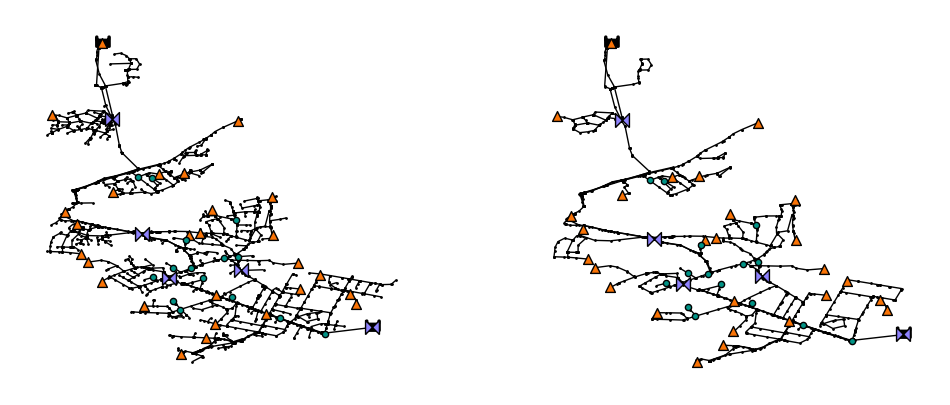

In [8]:
#define style object
style8 = vis.NetworkStyle(base_node_size=1, draw_base_legend = False,
                          reservoir_size=100, reservoir_border_width = 2, 
                          valve_size =100, valve_color ='xkcd:periwinkle')
sensor_color = 'xkcd:orange'
unique_dp_color = 'xkcd:teal'

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

#plot reduced network
model1=vis.VisWNModel('networks/BWFLnet_modified_level1.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

### Display reduction time and number of elements

In [9]:
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn2.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn2.num_pipes, "\033[0;0m")

Total reduction time: 1.82 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  1425 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  1480 


We generated a much smaller model keeping all critical nodes. The process only took a few seconds.

## 2.3. Reduce nodes with ```max_nodal_degree``` = 2 (branch trimming + merging pipes in series and parallel)

Next, we will reduce the same model defining a different  ```max_nodal_degree ``` each time to see how this impacts the results.

C:\Users\ps28866\AppData\Local\anaconda3\envs\wntr_env\lib\site-packages\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 3.42 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  209 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  257 


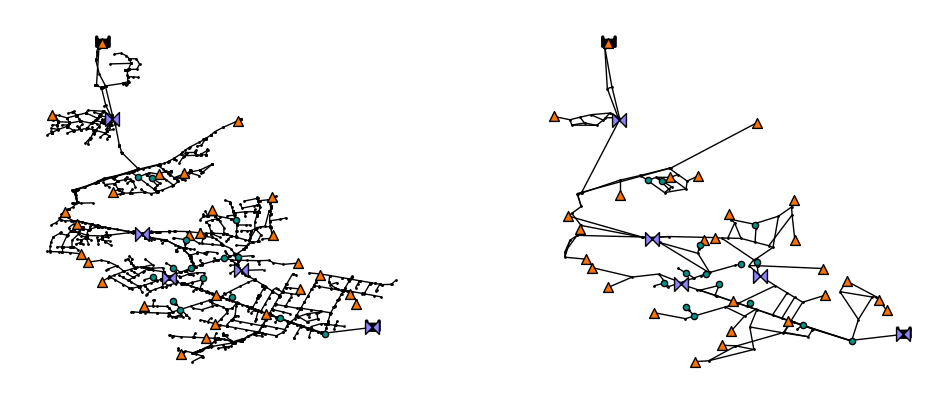

In [10]:
max_nodal_degree2 = 2

#call model reduction
t1 = time.time()
wn3 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree2, 'networks/BWFLnet_modified_level2')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

#plot reduced network
model1=vis.VisWNModel('networks/BWFLnet_modified_level2.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn3.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn3.num_pipes, "\033[0;0m")

## 2.4. Reduce nodes with ```max_nodal_degree``` = 3

C:\Users\ps28866\AppData\Local\anaconda3\envs\wntr_env\lib\site-packages\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 3.21 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  138 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  210 


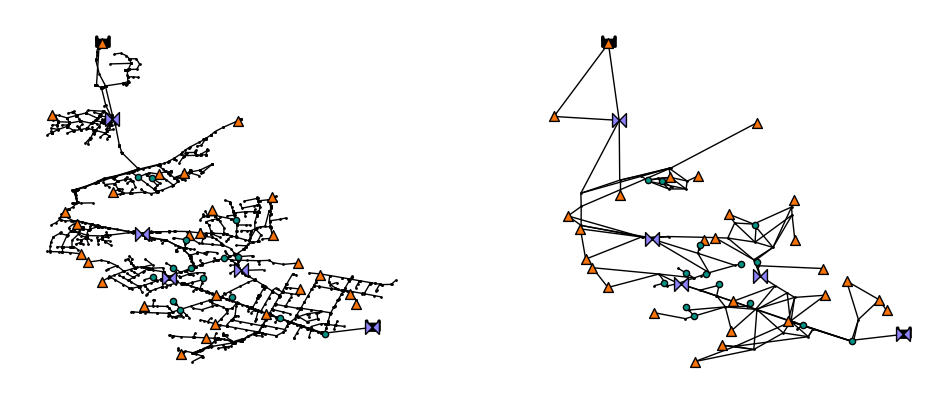

In [11]:
max_nodal_degree3 = 3

#call model reduction
t1 = time.time()
wn4 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree3, 'networks/BWFLnet_modified_level3')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

#plot reduced network
model1=vis.VisWNModel('networks/BWFLnet_modified_level3.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')
# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn4.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn4.num_pipes, "\033[0;0m")

## 2.5. Reduce nodes with ```max_nodal_degree``` = None 

All junctions that are not in the critical_nodes list or connected to reservoirs, tanks, pumps, or valves will be removed.

C:\Users\ps28866\AppData\Local\anaconda3\envs\wntr_env\lib\site-packages\magnets\utils\characteristics.py:161: UserWarning: Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.
  warnings.warn('Some values in list of nodes to keep provided by user do not exist in the model or have already been classified as special nodes. These values have been ignored.')


Total reduction time: 3.77 s
Number of junctions in the original network:  2546  vs. number of junctions in the reduced network:  84 
Number of pipes in the original network:  2601  vs. number of pipes in the reduced network:  352 


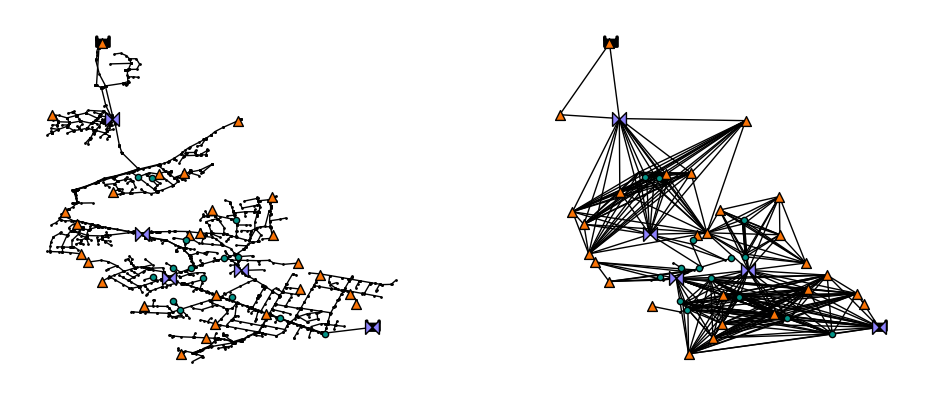

In [12]:
max_nodal_degree = None

#call model reduction
t1 = time.time()
wn5 = mg.reduction.reduce_model(inp, op_pt, critical_nodes, max_nodal_degree,'networks/BWFLnet_modified_full')
t2 = time.time()

#plot full network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(inp)
model.plot_basic_elements(ax=ax[0], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[0], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[0], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')

#plot reduced network
model1=vis.VisWNModel('networks/BWFLnet_modified_full.inp')
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], style = style8)
# highlight pressure sensors
model.draw_nodes(ax=ax[1], node_list=pressure_sensors_list, node_color=sensor_color, node_size=50,
                 node_shape ='^', node_border_width = 1, node_border_color = 'k')  
# highlight nodes with different demand patterns
model.draw_nodes(ax=ax[1], node_list=diff_demand_pattern_list, node_color=unique_dp_color,  node_size=20,
                 node_shape ='o', node_border_width = 1, node_border_color = 'k')
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn5.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn5.num_pipes, "\033[0;0m")

As can be seen from the graphs above, the reduced networks vary greatly and the reduction time increases as the maximum nodal degree increases. 

## 2.6. Comparing simulated pressures

We will now compare the pressures at two critical nodes to evaluate how the reduced models compare to the full model.

### Run simulations and track running times

In [13]:
sim = wntr.sim.EpanetSimulator(wn)
t1 = time.time()
results = sim.run_sim()
t2 = time.time()
sim_time_orig = t2-t1

sim2 = wntr.sim.EpanetSimulator(wn2)
t1 = time.time()
results2 = sim2.run_sim()
t2 = time.time()
sim_time_1 = t2-t1

sim3 = wntr.sim.EpanetSimulator(wn3)
t1 = time.time()
results3 = sim3.run_sim()
t2 = time.time()
sim_time_2 = t2-t1

sim4 = wntr.sim.EpanetSimulator(wn4)
t1 = time.time()
results4 = sim4.run_sim()
t2 = time.time()
sim_time_3 = t2-t1

sim5 = wntr.sim.EpanetSimulator(wn5)
t1 = time.time()
results5 = sim5.run_sim()
t2 = time.time()
sim_time_none = t2-t1

### Plot time series

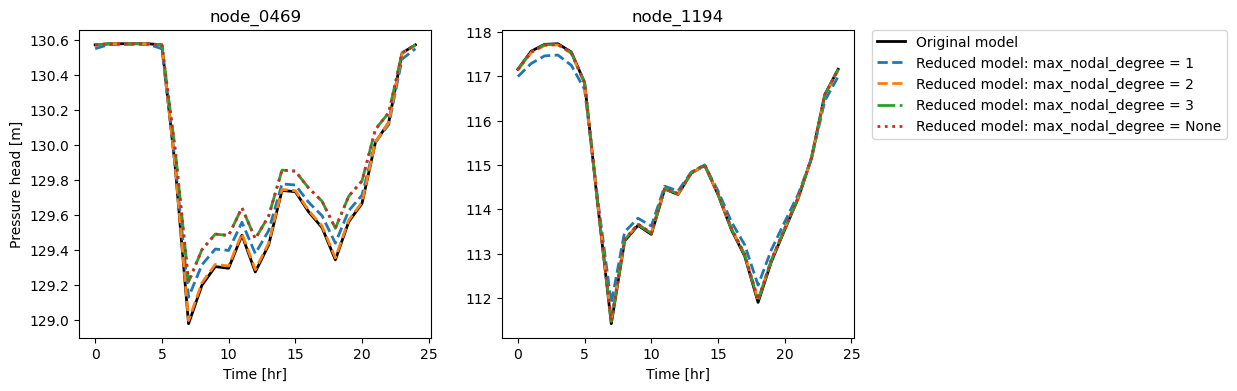

In [14]:
#comparing the head at two different nodes in the regular and reduced networks: 
node1, node2 = 'node_0469', 'node_1194'

#obtain head data for each network
head=results.node['head']
head2 = results2.node['head']
head3=results3.node['head']
head4=results4.node['head']
head5=results5.node['head']

#obtain data for critical nodes
head_at_node1, head_at_node2 = head.loc[:,node1], head.loc[:,node2]
reduced_head_at_node1_2, reduced_head_at_node2_2 = head2.loc[:,node1], head2.loc[:,node2]
reduced_head_at_node1_3, reduced_head_at_node2_3 = head3.loc[:,node1], head3.loc[:,node2]
reduced_head_at_node1_4, reduced_head_at_node2_4 = head4.loc[:,node1], head4.loc[:,node2]
reduced_head_at_node1_5, reduced_head_at_node2_5 = head5.loc[:,node1], head5.loc[:,node2]

#plot reduced and original model pressure head time series at two critical nodes 
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(head_at_node1.index/3600, head_at_node1, lw = 2, color = 'k')
ax[0].plot(reduced_head_at_node1_2.index/3600, reduced_head_at_node1_2, linestyle = '--', lw = 2)
ax[0].plot(reduced_head_at_node1_3.index/3600, reduced_head_at_node1_3, linestyle = '--', lw = 2)
ax[0].plot(reduced_head_at_node1_4.index/3600, reduced_head_at_node1_4, linestyle = '-.', lw = 2)
ax[0].plot(reduced_head_at_node1_5.index/3600, reduced_head_at_node1_5, linestyle = ':', lw = 2)
ax[0].set_title(node1)
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Pressure head [m]')


ax[1].plot(head_at_node2.index/3600, head_at_node2, lw = 2, color = 'k')
ax[1].plot(reduced_head_at_node2_2.index/3600, reduced_head_at_node2_2, linestyle = '--', lw = 2)
ax[1].plot(reduced_head_at_node2_3.index/3600, reduced_head_at_node2_3, linestyle = '--', lw = 2)
ax[1].plot(reduced_head_at_node2_4.index/3600, reduced_head_at_node2_4, linestyle = '-.', lw = 2)
ax[1].plot(reduced_head_at_node2_5.index/3600, reduced_head_at_node2_5, linestyle = ':', lw = 2)
ax[1].set_title(node2)
ax[1].set_xlabel('Time [hr]')
ax[1].legend(['Original model', 'Reduced model: max_nodal_degree = 1','Reduced model: max_nodal_degree = 2', 'Reduced model: max_nodal_degree = 3','Reduced model: max_nodal_degree = None'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## 2.7. Compare running times

Let us examine the simulation running times (in seconds) and speed up (decrease in running time compared to the original model).

In [15]:
import pandas as pd
data = np.array([[sim_time_orig, sim_time_orig/sim_time_orig], 
                 [sim_time_1, sim_time_orig/sim_time_1], 
                 [sim_time_2, sim_time_orig/sim_time_2], 
                 [sim_time_3, sim_time_orig/sim_time_3], 
                 [sim_time_none, sim_time_orig/sim_time_none]]).T
pd.DataFrame(data, 
             columns=['Original model', 'Reduced model: degree 1','Reduced model: degree 2', 'Reduced model:degree 3','Reduced model: degree None'],
            index=['Running time [s]', 'Speedup']).round(2)

,Original model,Reduced model: degree 1,Reduced model: degree 2,Reduced model:degree 3,Reduced model: degree None
Running time [s],0.4,0.27,0.10,0.08,0.08
Speedup,1.0,1.51,4.05,4.94,4.88


We can see that the reduced models run much faster than the original model. All of these results demonstrate that reduced models can be used in a range of studies and applications to **speed up simulation running times** while **preserving pressures throughout the system**. 

**Note**: Users should carefully choose the: (1) nodes to keep, (2) degree of reduction, and (3) operating point, when creating the reduced models. 

# 3. Exercise

Use MAGNets to reduce network **ky2**. Try changing the operating point (```op_pt```) and (```max_nodal_degree```) arguments in **Cell 3.1.** to see how the pressure head results and reduced model topology change in **Cell 3.2.**:

## 3.1.  Perform model reduction

In [17]:
#define inp_file
inp_ky4 = 'networks/ky2.inp'
wn_ky4 = wntr.network.WaterNetworkModel(inp_ky4)

op_pt = 0                         # change the operating point: e.g., 5, 10, 15, 20  
max_nodal_degree_ky4 = 1          # change the max nodal degree, e.g., 1, 2, 3, None

#call model reduction
t1 = time.time()
wn_ky4_red = mg.reduction.reduce_model(inp_file = inp_ky4,
                                op_pt = op_pt,
                                nodes_to_keep = [],
                                max_nodal_degree = max_nodal_degree_ky4,
                                save_filename = 'networks/reduced ky2')  
t2 = time.time()

#display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn_ky4.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn_ky4_red.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn_ky4.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn_ky4_red.num_pipes, "\033[0;0m")

Total reduction time: 0.39 s
Number of junctions in the original network:  811  vs. number of junctions in the reduced network:  593 
Number of pipes in the original network:  1124  vs. number of pipes in the reduced network:  897 


## 3.2. Plot network layout and time series comparison

Text(0.5, 0, 'Time [hr]')

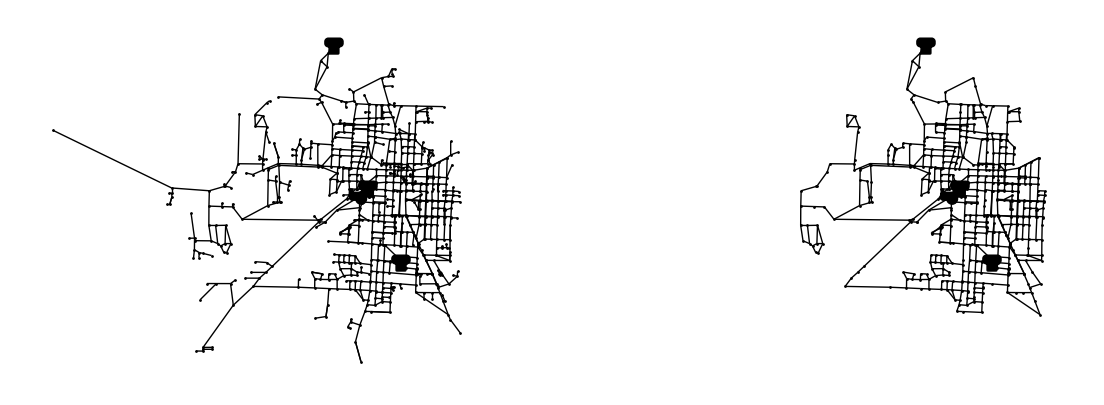

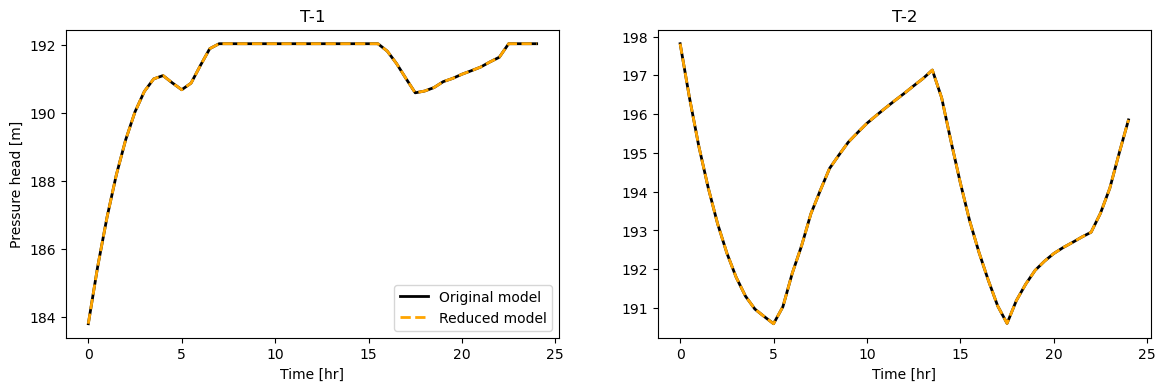

In [18]:
#plot full network
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].set_frame_on(False)
model=vis.VisWNModel(network_model=wn_ky4)
model.plot_basic_elements(ax=ax[0], style = style8)

#plot reduced network
model1=vis.VisWNModel(network_model=wn_ky4_red)
ax[1].set_frame_on(False)
model1.plot_basic_elements(ax=ax[1], style = style8)
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

#comparing the head at two different nodes in the regular and reduced networks: 
node1, node2 = 'T-1', 'T-2'
sim_ky4 = wntr.sim.EpanetSimulator(wn_ky4)
results_ky4 = sim_ky4.run_sim()

sim_ky4_red = wntr.sim.EpanetSimulator(wn_ky4_red)
results_ky4_red = sim_ky4_red.run_sim()

#obtain head data for each network
head, head2 = results_ky4.node['head'], results_ky4_red.node['head']

#obtain data for critical node 1
head_at_node1, reduced_head_at_node1 = head.loc[:,node1], head2.loc[:,node1]

#obtain data for critical node 2
head_at_node2, reduced_head_at_node2 = head.loc[:,node2], head2.loc[:,node2]

#plot reduced and original model pressure head time series at two critical nodes 
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(head_at_node1.index/3600, head_at_node1, color='k', lw = 2)
ax[0].plot(reduced_head_at_node1.index/3600, reduced_head_at_node1, 
           linestyle = '--', color='orange', lw = 2)
ax[0].set_title(node1)
ax[0].set_xlabel('Time [hr]')
ax[0].set_ylabel('Pressure head [m]')
ax[0].legend(['Original model', 'Reduced model'])

ax[1].plot(head_at_node2.index/3600, head_at_node2, color='k', lw = 2)
ax[1].plot(reduced_head_at_node2.index/3600, reduced_head_at_node2, 
           linestyle = '--', color = 'orange', lw = 2)
ax[1].set_title(node2)
ax[1].set_xlabel('Time [hr]')


We hope you have found this tutorial useful. For more information:

[MAGNets Github repository](https://github.com/meghnathomas/MAGNets)

[MAGNets paper in the Journal of Water Resources Planning and Management](https://ascelibrary.org/doi/full/10.1061/JWRMD5.WRENG-5486)